## Imports

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import torch
import os
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM


/Users/qmy/opt/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Reading and Cleaning

In [2]:
text_path = 'formatted_cases/'
file = '../annotated_data.xlsx'
REGEX = r';+'
df = pd.read_excel(file)
df['What is the file number of the case?'] = df['What is the file number of the case?'].str.replace(' and ', ';')
df['What is the file number of the case?'] = df['What is the file number of the case?'].str.replace(' ', ';')
df['What is the file number of the case?'] = df['What is the file number of the case?'].str.replace('/', ';')
df['What is the file number of the case?'] = df['What is the file number of the case?'].str.strip(';')
df['What is the file number of the case?'] = df['What is the file number of the case?'].apply(lambda x: re.sub(REGEX, ';', x))
df['What is the file number of the case?'] = df['What is the file number of the case?'].str.replace('File;number:;', '')
print(df.shape)
df.head(6)

(702, 54)


,Timestamp,Email Address,What is the file number of the case?,What was the date of the hearing? [mm/dd/yyyy],What was the date of the decision? [mm/dd/yyyy],Who was the member adjudicating the decision?,What was the location of the landlord tenant board?,Did the decision state the landlord was represented?,Did the decision state the landlord attended the hearing?,Did the decision state the tenant was represented?,...,"Did the decision mention the tenant’s difficulty finding alternative housing for any reason e.g.physical limitations, reliance on social assistance, etc.?","If yes to the previous question, which of the following were applicable to the tenant?",Did the decision state the tenant was given prior notice for the eviction?,"If the tenant was given prior notice for the eviction, how much notice was given?",Did the decisions state postponement would result in the tenant accruing additional arrears?,Which other specific applications of the landlord or the tenant were mentioned?,Did the decision mention the validity of an N4 eviction notice?,Were there detail(s) in the decision not captured by this questionnaire that should be included?,Exec Review,Review Status
0,2020-11-18 00:31:40.706,dylan.juschko@mail.utoronto.ca,CEL-87788-19,2019-10-16 00:00:00,2020-06-04 00:00:00,Sonia Anwar-Ali,Toronto,Yes,NaN,No,...,No,NaN,No,NaN,No,L2: Application to End a Tenancy and Evict a T...,No,Tenant was a single mother with no support fro...,NaN,NaN
1,2020-11-18 19:26:29.581,dylan.juschko@mail.utoronto.ca,CEL-90549-19,2020-01-22 00:00:00,2020-01-10 00:00:00,Shelby Whittick,Mississauga,Yes,Yes,No,...,No,NaN,Yes,Not stated,Yes,No other specific applications were mentioned,No,NaN,AW,Complete
2,2020-12-24 09:19:21.479,kayly.machado@mail.utoronto.ca,TEL-94478-18,2018-10-31 00:00:00,2018-11-21 00:00:00,Ruth Carey (Vice Chair),Toronto,Yes,Yes,No,...,No,NaN,Yes,Not stated,No,N13: Notice to End your Tenancy Because the La...,No,Previous decision TEL-92736-18 < This decision...,AW,Complete
3,2020-12-24 06:13:17.400,kayly.machado@mail.utoronto.ca,TEL-94493-18,2018-10-31 00:00:00,2018-11-21 00:00:00,Ruth Carey (Vice Chair),Toronto,Yes,Yes,No,...,No,NaN,Yes,Not stated,No,No other specific applications were mentioned,No,There were 7 previous application for non-paym...,AW,Complete
4,2020-11-19 17:02:36.702,joseph.galinsky@mail.utoronto.ca,CEL-72994-18,2018-03-07 00:00:00,2018-03-14 00:00:00,Avril Cardoso,Mississauga,Yes,No,Yes,...,No,NaN,Yes,Not stated,No,No other specific applications were mentioned,No,Third Application by Landlord in past 6 months...,AW,Complete
5,2020-11-19 17:14:22.294,joseph.galinsky@mail.utoronto.ca,CEL-73021-18,2018-06-15 00:00:00,2018-06-18 00:00:00,Avril Cardoso,Mississauga,Yes,No,No,...,No,NaN,Yes,Not stated,No,L1: Application to Evict a Tenant for Non-paym...,No,Tenant did not show up because hearing took pl...,AW,Complete


In [54]:
# to check if the data are well cleaned
multi = 0
for i in df['What is the file number of the case?']:
    if ';' in i:
        print(i)
        multi += 1
multi

TET-89650-18;TET-89650-18
TNL-00793-18;TNL-01183-18
TNL-03299-18;TNT-00589-17
TNL-04435-18;TNL-03907-18
HOL-02144-17;HOT-02146-17
TEL-87475-18;TET-86819-17;TET-88355-18
SWL-08112-17;SWL-08113-17
SWL-12547-18;SWL-12548-18
SWL-13901-18;SWT-14627-18
TEL-77442-17;TET-77790-17
TEL-77505-17-RV;TEL-77505-17
TNL-06025-18;TNL-06026-18
TEL-79519-17;TET-79366-17
TSL-93207-18-RV;TST-94747-18;TSL-00082-18
CEL-72209-17;CET-73173-18


15

In [4]:
text = []
for file_name in os.listdir(text_path):
    if 'checkpoints' not in file_name:
        with open (text_path+file_name, encoding='latin-1') as f:
            text.append(f.read())

In [5]:
len(text)

680

In [6]:
stopwords = ['a', 'the', 'an', 'à', 'this', 'that']

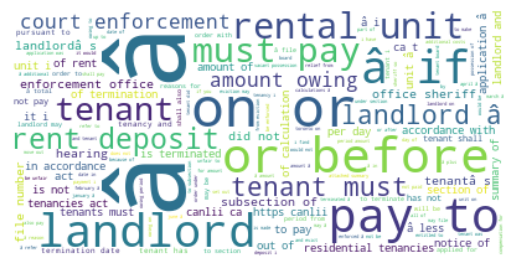

In [7]:
# annotated data wordcloud
tokens = ' '.join(text).lower()
wordcloud = WordCloud(
    background_color = 'white',
    stopwords = stopwords
).generate(tokens)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [25]:
for file_name in os.listdir(text_path):
    file_no = file_name[:-4]
    txt = file_name[-4:]
    if ' and ' in file_no:
        # print(file_name)
        new_name = file_no.replace(' and ', ';') + txt
        os.rename(text_path+file_name, text_path+new_name)
        file_name = new_name
        file_no = file_name[:-4]
        # print(file_name)
    if '/' in file_no:
        # print(file_name)
        new_name = file_no.replace('//', ';') + txt
        os.rename(text_path+file_name, text_path+new_name)
        file_name = new_name
        file_no = file_name[:-4]
        # print(file_name)
    if ' ' in file_no:
        # print(file_name)
        new_name = file_no.replace(' ',';').strip(';') + txt
        os.rename(text_path+file_name, text_path+new_name)
        file_name = new_name
        file_no = file_name[:-4]
        # print(file_name)
    if ';' in file_no:
        # print(file_name)
        new_name = re.sub(REGEX, ';', file_no) + txt
        os.rename(text_path+file_name, text_path+new_name)
        file_name = new_name
        file_no = file_name[:-4]
        # print(file_name)
    if 'File;number:;' in file_no:
        new_name = file_n.replace('File;number:;', '') + txt
        os.rename(text_path+file_name, text_path+new_name)
        file_name = new_name
        file_no = file_name[:-4]     

CEL-72209-17;;CET-73173-18.txt
CEL-72209-17;CET-73173-18.txt
TEL-77442-17;;TET-77790-17.txt
TEL-77442-17;TET-77790-17.txt
TSL-93207-18-RV;;TST-94747-18;;TSL-00082-18.txt
TSL-93207-18-RV;TST-94747-18;TSL-00082-18.txt
TNL-06025-18;;TNL-06026-18.txt
TNL-06025-18;TNL-06026-18.txt
TEL-77505-17-RV;;TEL-77505-17.txt
TEL-77505-17-RV;TEL-77505-17.txt
SWL-12547-18;SWL-12548-18.txt
SWL-12547-18;SWL-12548-18.txt
TNL-03299-18;;TNT-00589-17.txt
TNL-03299-18;TNT-00589-17.txt
TEL-79519-17;;TET-79366-17.txt
TEL-79519-17;TET-79366-17.txt
TEL-87475-18;;TET-86819-17;;TET-88355-18.txt
TEL-87475-18;TET-86819-17;TET-88355-18.txt
TNL-00793-18;;TNL-01183-18.txt
TNL-00793-18;TNL-01183-18.txt


In [30]:
for file_name in os.listdir(text_path):
    if ';' in file_name:
        print(file_name)

In [9]:
# no need to scrape anymore
# file_no = df['What is the file number of the case?']

# canlii_search = 'https://www.canlii.org/en/#search/id='
# response = requests.get(canlii_search+file_no[0])
# soup = BeautifulSoup(response.content, 'html.parser')
# judge = soup.find_all('script')

In [10]:
df.columns   #`Timestamp` is not the time of the case

Index(['Timestamp', 'Email Address', 'What is the file number of the case?',
       'What was the date of the hearing? [mm/dd/yyyy]',
       'What was the date of the decision? [mm/dd/yyyy]',
       'Who was the member adjudicating the decision?',
       'What was the location of the landlord tenant board?',
       'Did the decision state the landlord was represented?',
       'Did the decision state the landlord attended the hearing?',
       'Did the decision state the tenant was represented?',
       'Did the decision state the tenant attended the hearing?',
       'Did the decision state the landlord was a not-for-profit landlord (e.g. Toronto Community Housing)?',
       'Did the decision state the tenant was collecting a subsidy?',
       'What was the outcome of the case?',
       'What was the length of the tenancy, or in other words, how long had the tenants lived at the residence in question? ',
       'What was the monthly rent?',
       'What was the amount of the rental de

In [11]:
info_lst = df.columns[2:]

In [27]:
cases_info = []
passed_cases = []
for i in range(len(df)):
    cases_info.append({})
    answers = df.iloc[i,2:]
    # to complete the scraping function
    # text = scraping(file_no)
    file_no = answers[0]
    if not os.path.isfile(text_path+file_no+'.txt'):
        print(f'The case with file number "{file_no}" does not exist. Skipping...')
        passed_cases.append(file_no)
    else:
        with open (text_path+file_no+'.txt') as t:
            cases_info[-1]['text'] = t.read()
    for j in range(len(answers)):
        q = info_lst[j]
        a = answers[j]
        cases_info[-1][q] = a
print(passed_cases)

The case with file number "TET-89650-18;TET-89650-18" does not exist. Skipping...
The case with file number "TNL-04435-18;TNL-03907-18" does not exist. Skipping...
The case with file number "HOL-02144-17;HOT-02146-17" does not exist. Skipping...
The case with file number "SWL-08112-17;SWL-08113-17" does not exist. Skipping...
The case with file number "SWL-13901-18;SWT-14627-18" does not exist. Skipping...
The case with file number "TSL-07666-19-RV" does not exist. Skipping...
['TET-89650-18;TET-89650-18', 'TNL-04435-18;TNL-03907-18', 'HOL-02144-17;HOT-02146-17', 'SWL-08112-17;SWL-08113-17', 'SWL-13901-18;SWT-14627-18', 'TSL-07666-19-RV']


In [49]:
sup_path = 'annotated_sup/'
if not os.path.exists(sup_path):
    os.makedirs(sup_path)
sup_urls = ['https://www.canlii.org/en/on/onltb/doc/2018/2018canlii113792/2018canlii113792.html?resultIndex=1',
            'https://www.canlii.org/en/on/onltb/doc/2018/2018canlii113807/2018canlii113807.html?resultIndex=1',
            'https://www.canlii.org/en/on/onltb/doc/2018/2018canlii111686/2018canlii111686.html?resultIndex=1',
            'https://www.canlii.org/en/on/onltb/doc/2018/2018canlii42485/2018canlii42485.html?resultIndex=1',
            'https://www.canlii.org/en/on/onltb/doc/2018/2018canlii88630/2018canlii88630.html?resultIndex=1',
            'https://www.canlii.org/en/on/onltb/doc/2019/2019canlii134569/2019canlii134569.html?resultIndex=1'
           ]

In [50]:
from selenium import webdriver
sup_html_path = 'annotated_sup_html/'
if not os.path.exists(sup_html_path):
    os.makedirs(sup_html_path)
    
driver = webdriver.Chrome()
# Loop through the case IDs and URLs
for i, url in enumerate(sup_urls):
    # Generate a file name based on the case ID
    filename = f"case_{i}.html"
    if os.path.isfile(os.path.join(sup_html_path, filename)):
        print(filename, "already added, skipping...")
    else:
        # Navigate to the URL
        driver.get(url)

        # Get the page source
        html_content = driver.page_source

        # Save the HTML content to a file
        with open(os.path.join(sup_html_path, filename), "w", encoding="utf-8") as file:
            file.write(html_content)

        print(f"Saved HTML content for case ID {i}.")

# Close the WebDriver
driver.quit()

Saved HTML content for case ID 0.
Saved HTML content for case ID 1.
Saved HTML content for case ID 2.
Saved HTML content for case ID 3.
Saved HTML content for case ID 4.
Saved HTML content for case ID 5.


In [51]:
for file in os.listdir(sup_html_path):
    # print(sup_html_path + file)
    try:
        if os.path.isfile(sup_html_path + file) and not file.startswith('.'):
            print("Adding ", file, "...")
            with open(sup_html_path + file) as f:
                html = f.read()
            soup = BeautifulSoup(html, "html.parser")

            # find metadata
            document_meta = soup.find("div", {"id": "documentMeta"}) 
            meta_items = document_meta.find_all("div", {"class": "row py-1"})

            case_ID = ""
            meta_data = []
            for meta_item in meta_items:
                children_text = []
                for x in meta_item.findChildren()[:2]:
                    children_text.append(x.text)
                child_string = '\t'.join(children_text)
                if "file number" in child_string.lower():
                    case_ID = child_string.split("\t")[1].strip()
                    # print(case_ID)
                meta_data.append(child_string)

            # print(meta_data)
            # find text
            document_body = soup.find("div", {"class": "documentcontent"}).get_text()

            # write to file
            with open(sup_path + case_ID + '.txt', 'w') as file:
                file.write('Metadata:\n')
                file.write('\n'.join(meta_data))
                file.write('Content:\n')
                file.write(document_body)
    except:
        print("Error with:", file)

Adding  case_0.html ...
Adding  case_1.html ...
Adding  case_2.html ...
Adding  case_3.html ...
Adding  case_4.html ...
Adding  case_5.html ...


In [53]:
multi_path = text_path + 'multiple_files'
for file in os.listdir(multi_path):
    print(file[:-4])

SWL-08112-17;SWL-08113-17
TNL-06025-18;TNL-06026-18
TSL-93207-18-RV;TST-94747-18;TSL-00082-18
.DS_S
CEL-72209-17;CET-73173-18
TNL-00793-18;TNL-01183-18
SWL-12547-18;SWL-12548-18
TET-89650-18;TEL-90138-18
TEL-77505-17-RV;TEL-77505-17
HOL-02144-17;HOT-02146-17
TNL-03299-18;TNT-00589-17
TEL-79519-17;TET-79366-17
TEL-77442-17;TET-77790-17
SWL-13901-18;SWT-14627-18
TEL-87475-18;TET-86819-17;TET-88355-18


In [28]:

tokenizer = AutoTokenizer.from_pretrained("gpt2")

model = AutoModelForCausalLM.from_pretrained("gpt2")

In [ ]:
stop_words = [
    "a", "an", "and", "are", "as", "at", "be", "but", "by", "for", "if", "in",
    "into", "is", "it",# "no", "not",
    "of", "on", "or", "such", "that", "the",
    "their", "then", "there", "these", "they", "this", "to", "was", "will", "with",
    "about", "all", "also", "any", "can", "could", "do", "does", "from", "has",
    "have", "how", "however", "i", "if", "may", "might", "my", "need", "our",
    "should", "so", "some", "than", "their", "them", "there", "these", "thing",
    "things", "think", "us", "want", "way", "we", "what", "when", "where", "which",
    "who", "why", "would", "you"]

## A test before fine-tuning

In [64]:
text = cases_info[55]['What is the file number of the case?']
with open (text_path+text+'.txt') as t:
    text = t.read()
text = text.replace('\n\n', '\n')[:1000]

In [61]:
toks = tokenizer(text)

In [ ]:
toks.keys()

In [65]:
q1 = list(cases_info[55].keys())[0]
q2 = list(cases_info[55].keys())[1]

In [66]:
a1 = cases_info[55][q1]
a2 = cases_info[55][q1]
a1_toks = tokenizer(a1)
a2_toks = tokenizer(a2)

In [67]:
q1 = text + list(cases_info[0].keys())[0]
q2 = text + list(cases_info[0].keys())[1]
q1_toks = tokenizer(q1)
q2_toks = tokenizer(q2)

In [84]:
input_ids = torch.tensor([
    # q1_toks['input_ids'],
    q2_toks['input_ids']
])
attn_mask = torch.tensor([
    # q1_toks['attention_mask'],
    q2_toks['attention_mask']
])
label = torch.tensor([
    # a1_toks['input_ids'],
    a2_toks['input_ids']
])
tokenizer.pad_token_id = tokenizer.eos_token_id

In [85]:
out = model.generate(input_ids=input_ids, 
                     attention_mask=attn_mask, 
                     return_dict_in_generate=True, 
                     output_scores=False, 
                     max_length=512,
                     temperature=0.5,
                     do_sample=True,
                     repetition_penalty=3.0,
                     top_k=10)
result = tokenizer.batch_decode(out["sequences"], skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [86]:
result

["Metadata:\nDate:\t2018-03-22\nFile number:\t\nTEL-81897-17\n\tTEL-81897-17\nCitation:\tTEL-81897-17 (Re), 2018 CanLII 42843 (ON LTB), <https://canlii.ca/t/hs1c6>, retrieved on 2023-05-16\thttps://canlii.ca/t/hs1c6\nContent:\n\nOrder under Section 69\nResidential Tenancies Act, 2006\n\xa0\nFile Number: TEL-81897-17\n\xa0\n\n\n\n\n\n\xa0\n\xa0\nO.I.\n(the 'Landlord') applied for an order to terminate the tenancy and evict M.L.\n(the 'Tenant') because the Tenant did not pay the rent that the Tenant owes.\n\xa0\nThis\napplication was heard in Lindsay on December 5, 2017, and March 19, 2018.\n\xa0\nThe Landlord’s corporate owner, D.V., the Landlord’s\nrepresentative, L.W., and the Tenant attended the hearing. The Tenant’s\nrepresentative, M.P., also attended the second day of the hearing. S.C.\ntestified on behalf of the Landlord. \n\xa0\nPreliminary Issue:\n\xa0\nBy\n     way of background, the residential complex is a mobile home park and the\n     Tenant rents three separate units in t

In [74]:
tokenizer.pad_token_id = tokenizer.eos_token_id

out = model.generate(
    input_ids=input_ids,
    attention_mask=attn_mask,
    return_dict_in_generate=True,
    output_scores=False,
    max_length=512,
    temperature=0.5,
    do_sample=True,
    repetition_penalty=3.0,
    top_k=10
)

result = tokenizer.batch_decode(out["sequences"], skip_special_tokens=True)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
@torch.no_grad()
def answer(model, loader):
    all_preds = []
    all_labels = []
    model.eval()
    for batch in loader:   
        batch = to_device(batch, device)
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        # pos_ids = batch["position_ids"]
        labels = batch["labels"]
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, return_dict_in_generate=True, pad_token_id=50256, max_length=512, top_k=10, stopping_criteria=stop_criteria_list)
        pred_start = torch.nonzero(input_ids==tokenizer.sep_token_id, as_tuple=True)[1][0] + 1
        truncated_outputs = []
        for out in outputs["sequences"]:
            sep_idxs = torch.nonzero(out==tokenizer.sep_token_id, as_tuple=True)[0]
            if len(sep_idxs) == 1:
                end_idx = -1
            else:
                end_idx = sep_idxs[1]
            truncated_outputs.append(out[pred_start:end_idx])
        decode_texts = tokenizer.batch_decode(truncated_outputs)
        gold_texts = tokenizer.batch_decode([l[l != -100][:-1] for l in labels])

        for gold, decode in zip(gold_texts, decode_texts):
            l = set(gold.replace(" ", "").split("、"))
            p = set(decode.replace(" ", "").split("、"))
            all_labels.append(l)
            all_preds.append(p)
        
        all_preds = process_sys(all_preds)
    
    return all_preds, all_labels


def f1_score(sys, gold):
    tp = 0
    t = 0
    p = 0
    for s, g in zip(sys, gold):
        t += len(g)
        p += len(s)
        tp += len(g & s)
    precision = tp / p if p != 0 else 0
    recall = tp / t if t != 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    return precision, recall, f1, tp, t, p


def left_pad_sequence(sequence, batch_first, padding_value=0):
    padded = []
    max_len = max(len(each) for each in sequence)
    for each in sequence:
        if not isinstance(each, torch.LongTensor):
            each = torch.LongTensor(each)
        pad = torch.full((max_len-len(each),), fill_value=padding_value,dtype=each.dtype)
        padded.append(torch.cat([pad, each]))
    padded = torch.vstack(padded)
    if not batch_first:
        padded = padded.permute(1, 0, 2)
    return padded
        
def inference_colate_fn(batch):
    batch_input_ids = [torch.LongTensor(each["input_ids"]) for each in batch]
    batch_att_mask = [torch.LongTensor(each["attention_mask"]) for each in batch]
    batch_label = [torch.LongTensor(each["labels"]) for each in batch]
    batch_position_ids = [torch.arange(len(each["input_ids"]), dtype=torch.long) for each in batch]
    
    padded_batch_input_ids = left_pad_sequence(batch_input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    padded_batch_att_mask = left_pad_sequence(batch_att_mask, batch_first=True, padding_value=0)
    padded_batch_label = pad_sequence(batch_label, batch_first=True, padding_value=-100)
    # padded_batch_position_ids = left_pad_sequence(batch_position_ids, batch_first=True, padding_value=0)
    # return {"input_ids": padded_batch_input_ids, "attention_mask": padded_batch_att_mask, "position_ids":padded_batch_position_ids, "labels": padded_batch_label}   
    return {"input_ids": padded_batch_input_ids, "attention_mask": padded_batch_att_mask, "labels": padded_batch_label}    

val_dataset.inference()
inf_loader = DataLoader(val_dataset, batch_size=64, collate_fn=inference_colate_fn)

In [ ]:
a = torch.tensor([[1.,2.,3.],[4.,5.,6.]])
a

In [ ]:
# a.norm(dim=0, keepdim=True)

In [ ]:
a.norm(dim=-1, keepdim=True)

In [ ]:
a /= a.norm(dim=-1, keepdim=True)
a

In [ ]:
0.2673 + 0.5345 + 0.8018

In [ ]:
dists = torch.tensor([[2.,1.,3.],[4.,5.,6.]])

# Define number of nearest neighbors to find
n_neighbors = 2

# Compute top-k indices and values
top_k_values, top_k_indices = torch.topk(dists, n_neighbors, largest=False, dim=-1)

# Output top-k indices and values
print(top_k_indices)
print(top_k_values)

In [ ]:
gs = df.groupby('Who was the member adjudicating the decision?')

In [ ]:
for g in gs:
    if g[0] == 'Sonia Anwar-Ali':
        for _, r in g[1].iterrows():
            print(r.Timestamp)